# Install simpy :

In [1]:
!pip install simpy==4.0.1

# Import libraries :

In [2]:
import math
import simpy
import random
import statistics
import numpy as np
import matplotlib.pyplot as plt

# Utilities

Extent the simpy.Container class to allow the container keep the user(station) who is requesting resource(vehivle) in a list :

In [3]:
class MyContainer(simpy.Container):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.stations = []

    def get(self, station, *args, **kwargs):
        self.stations.append(station)
        return super().get(*args, **kwargs)

    def put(self, station, *args, **kwargs,):
        self.stations.remove(station)
        return super().put(*args, **kwargs)

In [4]:
from collections import namedtuple

Vehicle = namedtuple('Vehicle', 'id, Container, status')

The functions for computing the mean and max waiting time: 

In [5]:
def get_average_wait_time(wait_times):
    average_wait = statistics.mean(wait_times)
    # Pretty print the results
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

In [6]:
def get_max_wait_time(wait_times):
    average_wait = max(wait_times)
    # Pretty print the results
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

# Debug flags

In [7]:
debug_sta = False # Debug log for station and depot station.
debug_pax = False # Debug log for passenger.
REFILL_FLAG = True # Refilling strategy switch
PATIENCE_FLAG = True # Patience strategy switch
SHOW_RESULT_FLAG = False # Show result switch

# Station :

* Init with init_rato × capacity(the number of docks in the station). 
* The monitor process : If #bikes/capacity is not in the range[reset_ratio, 1-reset_ratio], repositioning vehicle will be called to refill/remove bikes, resetting the station to a state that one half is empty, and one half is filled with bikes.

In [8]:
class Station(object):
    def __init__(self, env, id, depot_station, num_bikes, capacity, init_ratio, reset_ratio):
      self.env = env
      self.id = id
      self.bike = simpy.Container(env, init=num_bikes, capacity=capacity)
      self.mon_proc = env.process(self.monitor_proc(env))
      self.depot_station = depot_station
      self.calling_signal_start = self.env.event()
      self.calling_signal_start.succeed()
      self.capacity = capacity
      self.init_ratio = init_ratio
      self.reset_ratio = reset_ratio

    def get_bike(self, passenger):
        yield self.env.timeout(random.randint(1, 3))

    def put_bike(self, passenger):
        yield self.env.timeout(random.randint(1, 3))
  
    def reset_station(self):
        yield self.env.timeout(random.randint(5, 10))
        #if debug_sta : print(f'Station   [{self.id}] Repositioning vehicle arriving at :{self.env.now}, Current N.bikes : ({self.bike.level})')
        amount = math.ceil(self.bike.capacity//2 - self.bike.level)
        if amount > 0:  
          yield self.bike.put(amount)
          if debug_sta : print(f'Station   [{self.id}] Bikes filled at :{self.env.now} with amount {amount}, Current N.bikes : ({self.bike.level})')
        elif amount < 0:
          yield self.bike.get(abs(amount))
          if debug_sta : print(f'Station   [{self.id}] Bikes removed at :{self.env.now} with amount {abs(amount)}, Current N.bikes : ({self.bike.level})')
        else:
          if debug_sta : print(f'Station   [{self.id}] Bikes in station already balanced, Current N.bikes : ({self.bike.level})')

    def monitor_proc(self, env):
        while True:
          yield self.calling_signal_start
          if self.bike.level <= self.capacity*self.reset_ratio or self.bike.level >= self.capacity*(1-self.reset_ratio):
            self.calling_signal_start = self.env.event()
            #if debug_sta : print(f'Station [{self.id}] Calling repositioning vehicle at :{env.now}, Current N.bikes : ({self.bike.level})')
            try:
              c_id, repo_vehicle, _ = self.depot_station.vehicle_store[[index for index, a_tuple in enumerate(self.depot_station.vehicle_store) if a_tuple.status == True].pop()]
              if repo_vehicle.level <= repo_vehicle.capacity - self.depot_station.reset_threshold:
                self.depot_station.modify_activate(c_id, False)
              yield repo_vehicle.get(self, 1)
              if c_id:
                if debug_sta : print(f'Station [{self.id}] bikes: {self.bike.level}, Request a vehicle {c_id} at :{env.now}')
            except IndexError:
              pass
          yield self.env.timeout(1) # check the status every 1 minutes 

# Depot Station :

* Init with capacity(num_vehicles). A vehicle is a container with capacity 10, meaning one vehicle can only serve at most 10 stations during one trip.
* The monitor process : when a vehicle receives calls from some number of stations,  then it start departing to serve them. Note the number could be different in peak commuting hours.

In [9]:
class Depot_Station(object):
  def __init__(self, env, num_vehicles, num_stations, reset_threshold, reset_delay):
        self.env = env
        self.reset_delay = reset_delay
        self.vehicle_store = [Vehicle(id, MyContainer(env, init=num_stations//2, capacity=num_stations//2), True) for id in range(num_vehicles)]
        self.reset_threshold = reset_threshold
        for c_id in range(num_vehicles):
          self.mon_proc = env.process(self.monitor_proc(env, c_id))
        
  def count(self):
      v_count = 0
      for _, _, status in self.vehicle_store:
        if status: v_count += 1
      return v_count

  def modify_activate(self, c_id, status):
      id_vehicle = [index for index, a_tuple in enumerate(self.vehicle_store) if a_tuple.id == c_id].pop()
      vehicle = self.vehicle_store[id_vehicle]
      temp = list(vehicle)
      temp[2] = status
      self.vehicle_store[id_vehicle] = Vehicle._make(temp)

  def monitor_proc(self, env, c_id):
      global num_vehicles_in_use
      global repo_frequency
      global log_num_vehicles_in_use
      global log_repo_frequency
      vehicle_signal_start = self.env.event()

      while REFILL_FLAG:
        c_id, repo_vehicle, status = self.vehicle_store[[index for index, a_tuple in enumerate(self.vehicle_store) if a_tuple.id == c_id].pop()]
        if not status: vehicle_signal_start.succeed()

        # Delay rate will decrease during the day:
        if (6*60 <= self.env.now <= 10*60) or (16*60 <= self.env.now <= 20*60):
          delay_rate = peak_rate*0.5 # delay_rate = 2.5
        elif (10*60 < self.env.now < 16*60):
          delay_rate = noon_rate*0.5 # delay_rate = 1
        else:
          delay_rate = night_rate*0.5 # delay_rate = 0.5

        departure_time_interval = self.reset_delay//delay_rate
        waiting_event = self.env.timeout(departure_time_interval)
        yield vehicle_signal_start | waiting_event
        vehicle_signal_start = self.env.event()

        if len(repo_vehicle.stations) > 0:
          num_vehicles_in_use = self.count()
          log_num_vehicles_in_use.append((self.env.now, num_vehicles_in_use))
          repo_frequency += 1
          log_repo_frequency.append((self.env.now, repo_frequency))
          if debug_sta : print(f'Depot Station assign a vehicle {c_id}, N.stations : {10 - repo_vehicle.level} at :{env.now}')
          self.modify_activate(c_id, False)
          if debug_sta : print(f"Reset stations: N.stations : {len(repo_vehicle.stations)}, level : {repo_vehicle.level}")
          stas = []
          for station in repo_vehicle.stations:
            stas.append(station)
          for station in stas:
            if debug_sta : print(f"{station.id}, sta_list : {[station.id for station in repo_vehicle.stations]}, stas_list : {[station.id for station in stas]}")
            yield self.env.process(station.reset_station())
            if debug_sta : print(f"Stations: [{station.id}] got reset at :{env.now}")
            yield repo_vehicle.put(station, 1)
            station.calling_signal_start.succeed()

          num_vehicles_in_use = self.count()
          log_num_vehicles_in_use.append((self.env.now, num_vehicles_in_use))
          self.modify_activate(c_id, True)
        yield self.env.timeout(1) # check the status every 1 minutes

# Passenger :

* Passengers are generated with different arrival rates in five periods(early-hours, morning, noon, evening, midnight), amounting to around 3720 per day. The time interval between two consecutive passenger follows the exponential distribution.
* Passengers have a limited patience to get/put a bike
  * (10, 20) minutes to get a bike, otherwise they would leave.
  * (20, 30) minutes to put a bike, otherwise they may not park the bike in the dock properly.

In [10]:
class Passenger(object):
  def __init__(self, env, passenger_id, start_station, end_station):
    self.env = env
    self.passenger_id = passenger_id
    self.start_station = start_station
    self.end_station = end_station

  def behave(self):
    global num_passengers_waiting
    global num_passengers_served
    global num_bike_in_use
    global num_impatiences_get
    global num_impatiences_put
    global num_passengers
    global log_num_passengers_waiting
    global log_num_passengers_served
    global log_num_bikes_in_use
    global log_wait_times
    global log_num_impatiences_get
    global log_num_impatiences_put


    """ Get a bike """
    # passenger arrives
    arrival_time = self.env.now

    # requring a bike
    if debug_pax : print(f"Passenger <{self.passenger_id}> starting requiring a bike at :{self.env.now} on station [{self.start_station.id}], Current N.bikes : ({self.start_station.bike.level})")
    request = self.start_station.bike.get(1)
    num_passengers_waiting += 1
    log_num_passengers_waiting.append((self.env.now, num_passengers_waiting))
    num_passengers += 1
    log_num_passengers.append((self.env.now, num_passengers))

    if PATIENCE_FLAG:
      waiting_event = self.env.timeout(random.randrange(10,20))
      res = yield request | waiting_event
      if request in res:
        yield self.env.process(self.start_station.get_bike(self.passenger_id))
        num_bike_in_use += 1
        log_num_bikes_in_use.append((self.env.now, num_bike_in_use))
        if debug_pax : print(f"Passenger <{self.passenger_id}> get a bike at :{self.env.now} on station [{self.start_station.id}], Current N.bikes : ({self.start_station.bike.level})")
        num_passengers_waiting -= 1
        log_num_passengers_waiting.append((self.env.now, num_passengers_waiting))
        # passenger leaves the station
        log_wait_times.append((self.env.now, self.env.now - arrival_time))
      else:
        request.cancel()
        if debug_pax : print(f"Passenger <{self.passenger_id}> run out of patience at :{self.env.now} on station [{self.start_station.id}], Current N.bikes : ({self.start_station.bike.level})")
        num_impatiences_get += 1
        log_num_impatiences_get.append((self.env.now, num_impatiences_get))
        num_passengers_waiting -= 1
        log_num_passengers_waiting.append((self.env.now, num_passengers_waiting))
        # passenger leaves the station
        log_wait_times.append((self.env.now, self.env.now - arrival_time))
        return
    else:
      yield request
      yield self.env.process(self.start_station.get_bike(self.passenger_id))
      num_bike_in_use += 1
      log_num_bikes_in_use.append((self.env.now, num_bike_in_use))
      if debug_pax : print(f"Passenger <{self.passenger_id}> get a bike at :{self.env.now} on station [{self.start_station.id}], Current N.bikes : ({self.start_station.bike.level})")
      num_passengers_waiting -= 1
      log_num_passengers_waiting.append((self.env.now, num_passengers_waiting))
      # passenger leaves the station
      log_wait_times.append((self.env.now, self.env.now - arrival_time))


    """ Taveling """
    yield self.env.timeout(random.randint(10, 3*60))


    """ Put a bike """
    # passenger arrives
    arrival_time = self.env.now
    # putting a bike
    if debug_pax : print(f"Passenger <{self.passenger_id}> starting putting a bike at :{self.env.now} on station [{self.end_station.id}], Current N.bikes : ({self.end_station.bike.level})")
    request = self.end_station.bike.put(1)
    #print(f"222 Passenger <{self.passenger_id}> starting putting a bike at :{self.env.now} on station [{self.end_station.id}], Current N.bikes : ({self.end_station.bike.level})")
    num_passengers_waiting += 1
    log_num_passengers_waiting.append((self.env.now, num_passengers_waiting))

    if PATIENCE_FLAG:
      waiting_event = self.env.timeout(random.randrange(20,30))
      res = yield request | waiting_event
      if request in res:
        yield self.env.process(self.end_station.put_bike(self.passenger_id))
        if debug_pax : print(f"Passenger <{self.passenger_id}> put a bike at :{self.env.now} on station [{self.end_station.id}], Current N.bikes : ({self.end_station.bike.level})")
        num_passengers_served += 1
        log_num_passengers_served.append((self.env.now, num_passengers_served))
      else:
        request.cancel()
        if debug_pax : print(f"Passenger <{self.passenger_id}> run out of patience and throw away a bike at :{self.env.now} on station [{self.end_station.id}], Current N.bikes : ({self.end_station.bike.level})")
        num_impatiences_put += 1
        log_num_impatiences_put.append((self.env.now, num_impatiences_put))
      # passenger leaves the station
      num_bike_in_use -= 1
      log_num_bikes_in_use.append((self.env.now, num_bike_in_use))
      num_passengers_waiting -= 1
      log_num_passengers_waiting.append((self.env.now, num_passengers_waiting))
      log_wait_times.append((self.env.now, self.env.now - arrival_time))
    else:
      yield request
      yield self.env.process(self.end_station.put_bike(self.passenger_id))
      num_bike_in_use -= 1
      log_num_bikes_in_use.append((self.env.now, num_bike_in_use))
      if debug_pax : print(f"Passenger <{self.passenger_id}> put a bike at :{self.env.now} on station [{self.end_station.id}], Current N.bikes : ({self.end_station.bike.level})")
      num_passengers_waiting -= 1
      log_num_passengers_waiting.append((self.env.now, num_passengers_waiting))
      num_passengers_served += 1
      log_num_passengers_served.append((self.env.now, num_passengers_served))
      # passenger leaves the station
      log_wait_times.append((self.env.now, self.env.now - arrival_time))

# Main :

* Run the system.

In [11]:
def run_system(env, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay):
  depot_station = Depot_Station(env, num_vehicles, num_stations, reset_threshold, reset_delay)
  stations = [Station(env, id, depot_station, math.ceil(capacity*init_ratio), capacity, init_ratio, reset_ratio) for id in range(num_stations)]
  day_splitting = {
      "early-hours" : (night_duration/2, night_rate),
      "morning" : (morning_duration, peak_rate),
      "noon" : (noon_duration, noon_rate),
      "evening" : (evening_duration, peak_rate),
      "midnight" : (night_duration/2, night_rate)
  }
  passenger_id = 0

  for _, (duration, rate) in day_splitting.items():
    period = 0
    while (period <= duration):
      start_station, end_station = random.choice(stations), random.choice(stations)
      pax = Passenger(env, passenger_id, start_station, end_station)
      env.process(pax.behave())
      # Using the inverse CDF algorithm to generate passengers from the exponential distribution
      p = random.random()
      interval_arrival_time = -math.log(1.0 - p)/rate
      period += interval_arrival_time
      passenger_id += 1
      yield env.timeout(interval_arrival_time)

Run the environment.

In [12]:
def main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay):
  # Setup
  random.seed(42)

  # Run the simulation
  env = simpy.Environment()
  env.run(env.process(run_system(env, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)))

  # Save the results
  avg_mins, avg_secs = get_average_wait_time(list(zip(*log_wait_times))[-1])
  max_mins, max_secs = get_max_wait_time(list(zip(*log_wait_times))[-1])
  if SHOW_RESULT_FLAG:
    print( "-------------------------------------------------------------------"
        f"\nRunning simulation {id} times ...",
        f"\nNum_vehicles: {num_vehicles}, Num_stations : {num_stations}, Capacity : {capacity}, Init_ratio : {init_ratio}, Reset_ratio : {reset_ratio}, Reset_threshold : {reset_threshold}, Reset_delay : {reset_delay}"
        f"\nFinished at time :{env.now}",
        f"\nThe average wait time is {avg_mins} minutes and {avg_secs} seconds.",
        f"\nThe max wait time is {max_mins} minutes and {max_secs} seconds.",
        f"\nRefilling frequency : {log_repo_frequency[-1][-1] if log_repo_frequency else 0}.",
        f"\nNum_impatiences_get : {log_num_impatiences_get[-1][-1] if log_num_impatiences_get else 0}.",
        f"\nNum_impatiences_put : {log_num_impatiences_put[-1][-1] if log_num_impatiences_put else 0}.",
        f"\nNum_passengers arrived: {log_num_passengers[-1][-1] if log_num_passengers else 0}."
        f"\nNum_passengers served: {log_num_passengers_served[-1][-1] if log_num_passengers_served else 0}."
    )
  return avg_mins, avg_secs, max_mins, max_secs, log_repo_frequency[-1][-1] if log_repo_frequency else 0, log_num_impatiences_get[-1][-1] if log_num_impatiences_get else 0, log_num_impatiences_put[-1][-1] if log_num_impatiences_put else 0

# Parameters :

Grid search :
1. **num_stations** (20) : the number of stations. 
2. **num_vehicles** ([5,10,20]) : the number of vehicles in a depot station.
3. **capacity** ([5,15,25]) : the capacity of each station.
4. **init_ratio** ([0.6,0.7,0.8]) : #bikes / capacity in each station initially.
5. **reset ratio** ([0.1,0.3,0.5]) : #bikes/capacity to call for repositioning vehicles.
6. **reset_threshold** ([4,6,8]) : the number of stations received (10 - reset_threshold) for a vehicle to depart. 
7. **reset_delay** ([10,20,30]) : the time interval to send a vehicle.


In [13]:
if __name__ == '__main__':
  res = []
  logs_wait_times = []
  logs_repo_frequency = []
  logs_num_passengers = []
  logs_num_passengers_waiting = []
  logs_num_passengers_served = []
  logs_num_bikes_in_use = []
  logs_num_vehicles_in_use = []
  logs_num_impatiences_get = []
  logs_num_impatiences_put = []
  
  id = 0
  num_stations = 20
  """ num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """
  #for id, (num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay) in enumerate(parameters):
  for num_vehicles in [5,10,20]:
    for capacity in [5,15,25]:
      for init_ratio in [0.6,0.7,0.8]:
        for reset_ratio in [0.1,0.3,0.5]:
          for reset_threshold in [4,6,8]:
            for reset_delay in [10,20,30]:
              # Logs
              log_wait_times = []
              log_repo_frequency = []
              log_num_passengers = []
              log_num_passengers_waiting = []
              log_num_passengers_served = []
              log_num_bikes_in_use = []
              log_num_vehicles_in_use = []
              log_num_impatiences_get = []
              log_num_impatiences_put = []

              # Marco variables
              repo_frequency = 0
              num_impatiences_get = 0
              num_impatiences_put = 0
              num_passengers_waiting = 0
              num_passengers_served = 0
              num_passengers = 0
              num_bike_in_use = 0
              num_vehicles_in_use = 0
              peak_rate = 5 # morning lambda / evening lambda
              morning_duration = 60*4 # morning peak time duration in minutes
              noon_rate = 2 # noon lambda
              noon_duration = 60*6  # noon time duration in minutes
              evening_duration = 60*4  # evening peak time duration in minutes
              night_rate = 1 # evening lambda
              night_duration = 60*10  # evening peak time duration in minutes
              avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put = main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)
              res.append([id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put])
              logs_wait_times.append(log_wait_times)
              logs_repo_frequency.append(log_repo_frequency)
              logs_num_passengers.append(log_num_passengers)
              logs_num_passengers_waiting.append(log_num_passengers_waiting)
              logs_num_passengers_served.append(log_num_passengers_served)
              logs_num_bikes_in_use.append(log_num_bikes_in_use)
              logs_num_vehicles_in_use.append(log_num_vehicles_in_use)
              logs_num_impatiences_get.append(log_num_impatiences_get)
              logs_num_impatiences_put.append(log_num_impatiences_put)
              id += 1

# Results :

In [14]:
import tabulate
from IPython.display import display, HTML

def show_table(res):
    table = [[id] + [num_vehicles] + [capacity] + [init_ratio] + [reset_ratio] + [reset_threshold] + [reset_delay] + [f"{avg_mins} mins {avg_secs} secs"] + [f"{max_mins} mins {max_secs} secs"] + [ref_freq] + [num_impatiences_get] + [num_impatiences_put] for _, (id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put) in enumerate(res)]
    display(HTML(tabulate.tabulate(table, colalign=("center","center","center","center","center","center","center","center","center","center","center","center"), tablefmt='html', headers=["No."] + ["N.vehicles"] + ["Capacity"] + ["Init-ratio"] + ["Reset-ratio"] + ["Reset-threshold"] + ["Reset-delay"] + ["Average-waiting-time"] + ["Max-waiting-time"] + ["Refilling-times"] + ["N_impatiences_get"] + ["N_impatiences_put"])))

In [15]:
def set_css_in_cell_output():
  display(HTML("""<style>
table,th,td{border-spacing: 5px; border: 1px solid black; border-collapse: collapse;}
th{padding: 10px;}
</style>"""))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

In [16]:
res = sorted(res, key=lambda x: (x[-1]+x[-2], x[-3], x[1], x[3]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
696,20,25,0.7,0.5,6,10,1 mins 60 secs,13 mins 38 secs,244,0,0


In [17]:
res = sorted(res, key=lambda x: (x[-1]+x[-2], x[-3], x[3], x[1]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
696,20,25,0.7,0.5,6,10,1 mins 60 secs,13 mins 38 secs,244,0,0


In [18]:
res = sorted(res, key=lambda x: (x[-1]+x[-2], x[1], x[-3], x[3]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
423,10,25,0.6,0.5,4,10,1 mins 60 secs,10 mins 60 secs,288,0,0


In [19]:
res = sorted(res, key=lambda x: (x[-1]+x[-2], x[1], x[3], x[-3]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
423,10,25,0.6,0.5,4,10,1 mins 60 secs,10 mins 60 secs,288,0,0


In [20]:
res = sorted(res, key=lambda x: (x[-1]+x[-2], x[3], x[-3], x[1]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
696,20,25,0.7,0.5,6,10,1 mins 60 secs,13 mins 38 secs,244,0,0


In [21]:
res = sorted(res, key=lambda x: (x[-1]+x[-2], x[3], x[1], x[-3]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
423,10,25,0.6,0.5,4,10,1 mins 60 secs,10 mins 60 secs,288,0,0


In [22]:
res = sorted(res, key=lambda x: (x[-1]+x[-2], x[-3], x[3], x[1]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
696,20,25,0.7,0.5,6,10,1 mins 60 secs,13 mins 38 secs,244,0,0


In [23]:
res = sorted(res, key=lambda x: (x[-1]+x[-2], x[-3], x[1], x[3]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
696,20,25,0.7,0.5,6,10,1 mins 60 secs,13 mins 38 secs,244,0,0


In [24]:
res = sorted(res, key=lambda x: (x[-3], x[-1]+x[-2], x[1], x[3]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
197,5,25,0.7,0.1,8,30,2 mins 26 secs,31 mins 22 secs,48,75,21


In [25]:
res = sorted(res, key=lambda x: (x[-3], x[-1]+x[-2], x[3], x[1]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
197,5,25,0.7,0.1,8,30,2 mins 26 secs,31 mins 22 secs,48,75,21


In [26]:
res = sorted(res, key=lambda x: (x[-3], x[1], x[-1]+x[-2], x[3]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
197,5,25,0.7,0.1,8,30,2 mins 26 secs,31 mins 22 secs,48,75,21


In [27]:
res = sorted(res, key=lambda x: (x[-3], x[1], x[3], x[-1]+x[-2]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
197,5,25,0.7,0.1,8,30,2 mins 26 secs,31 mins 22 secs,48,75,21


In [28]:
res = sorted(res, key=lambda x: (x[-3], x[3], x[1], x[-1]+x[-2]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
197,5,25,0.7,0.1,8,30,2 mins 26 secs,31 mins 22 secs,48,75,21


In [29]:
res = sorted(res, key=lambda x: (x[-3], x[3], x[-1]+x[-2], x[1]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
197,5,25,0.7,0.1,8,30,2 mins 26 secs,31 mins 22 secs,48,75,21


In [30]:
res = sorted(res, key=lambda x: (x[1], x[-3], x[-1]+x[-2], x[3]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
197,5,25,0.7,0.1,8,30,2 mins 26 secs,31 mins 22 secs,48,75,21


In [31]:
res = sorted(res, key=lambda x: (x[1], x[-3], x[3], x[-1]+x[-2]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
197,5,25,0.7,0.1,8,30,2 mins 26 secs,31 mins 22 secs,48,75,21


In [32]:
res = sorted(res, key=lambda x: (x[1], x[-1]+x[-2], x[-3], x[3]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
229,5,25,0.8,0.3,6,20,2 mins 3 secs,26 mins 19 secs,101,4,0


In [33]:
res = sorted(res, key=lambda x: (x[1], x[-1]+x[-2], x[3], x[-3]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
229,5,25,0.8,0.3,6,20,2 mins 3 secs,26 mins 19 secs,101,4,0


In [34]:
res = sorted(res, key=lambda x: (x[1], x[3], x[-1]+x[-2], x[-3]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
0,5,5,0.6,0.1,4,10,6 mins 23 secs,30 mins 6 secs,174,966,142


In [35]:
res = sorted(res, key=lambda x: (x[1], x[3], x[-3], x[-1]+x[-2]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
53,5,5,0.7,0.5,8,30,6 mins 53 secs,30 mins 29 secs,78,1126,176


In [36]:
res = sorted(res, key=lambda x: (x[1], x[-3], x[-1]+x[-2], x[3]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
197,5,25,0.7,0.1,8,30,2 mins 26 secs,31 mins 22 secs,48,75,21


In [37]:
res = sorted(res, key=lambda x: (x[1], x[-3], x[3], x[-1]+x[-2]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
197,5,25,0.7,0.1,8,30,2 mins 26 secs,31 mins 22 secs,48,75,21


In [38]:
res = sorted(res, key=lambda x: (x[-1] + x[-2] + x[-3]))
show_table(res[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
176,5,25,0.6,0.3,6,30,2 mins 7 secs,28 mins 40 secs,75,6,6


In [39]:
filtered = filter(lambda item: item[1]<=20 and item[3]<=25 and item[-1]<=100 and item[-2]<=100 and item[-3]<=50, res)
res = sorted(filtered, key=lambda x: (x[-3] + x[1] + x[2]*x[3] + x[-2]+x[-1]))
show_table(list(res)[:1])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
197,5,25,0.7,0.1,8,30,2 mins 26 secs,31 mins 22 secs,48,75,21


# Plotting :

##  N.vehicles in use, N.passengers waiting, Passenger waiting times

In [40]:
""" Plot functions """
def plot_func(id, res):
  plt.rcParams["figure.figsize"] = (12,8)
  x1, y1 = list(zip(*logs_wait_times[res[id][0]]))
  plt.plot(x1, y1, label='Passenger waiting times')
  #x2, y2 = (list(zip(*logs_repo_frequency[res[id][0]])))
  #plt.plot(x2, y2, label='Refilling frequency')
  x3, y3 = (list(zip(*logs_num_passengers_waiting[res[id][0]])))
  plt.plot(x3, y3, label="Number of passengers waiting")
  #x4, y4 = (list(zip(*logs_num_bikes_in_use[res[id][0]])))
  #plt.plot(x4, y4, label="Number of bikes in use")
  x5, y5 = (list(zip(*logs_num_vehicles_in_use[res[id][0]])))
  plt.plot(x5, y5, label="Number of vehicles in use")
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.legend(loc='best')
  plt.title(f'No.{res[id][0]} : Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.show()

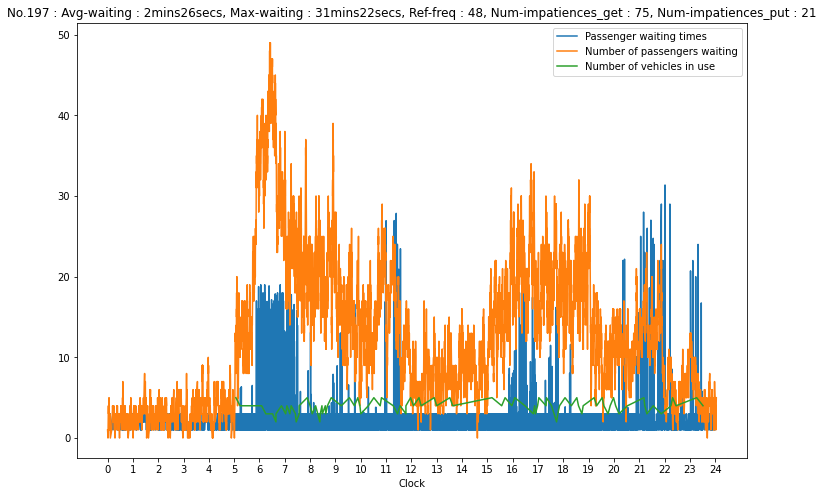

In [41]:
for id, (_) in enumerate(res[:1]):
  plot_func(id, res)

## N.passengers waiting

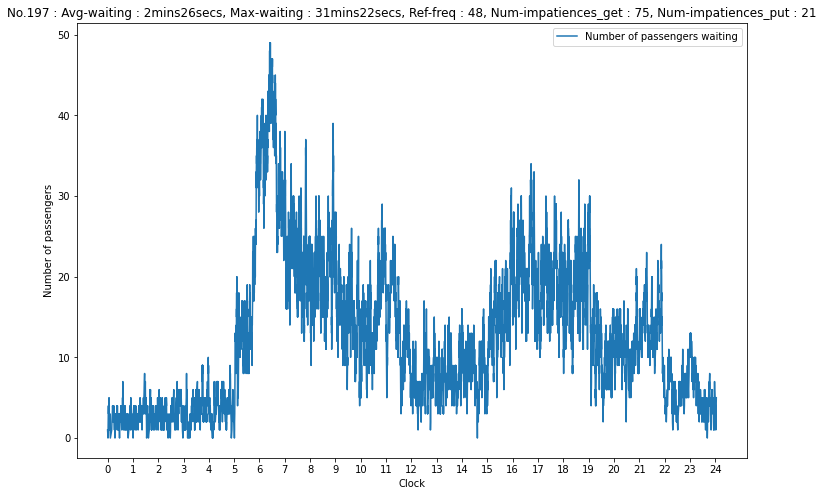

In [42]:
for id in [0]:
  x3, y3 = (list(zip(*logs_num_passengers_waiting[res[id][0]])))
  plt.plot(x3, y3, label="Number of passengers waiting")
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.ylabel("Number of passengers")
  plt.legend(loc='best')
  plt.title(f'No.{res[id][0]} : Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.show()

## N.bikes in use

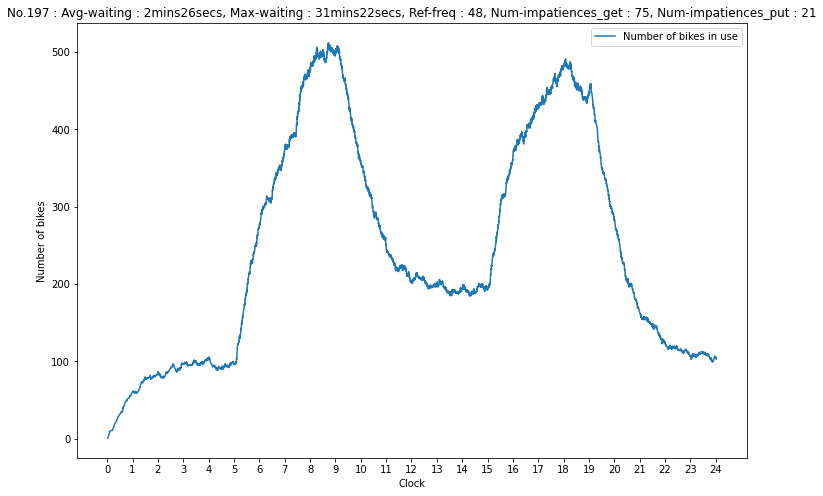

In [43]:
for id in [0]:
  x4, y4 = (list(zip(*logs_num_bikes_in_use[res[id][0]])))
  plt.plot(x4, y4, label="Number of bikes in use")
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.ylabel("Number of bikes")
  plt.legend(loc='best')
  plt.title(f'No.{res[id][0]} : Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.show()

## N.passengers

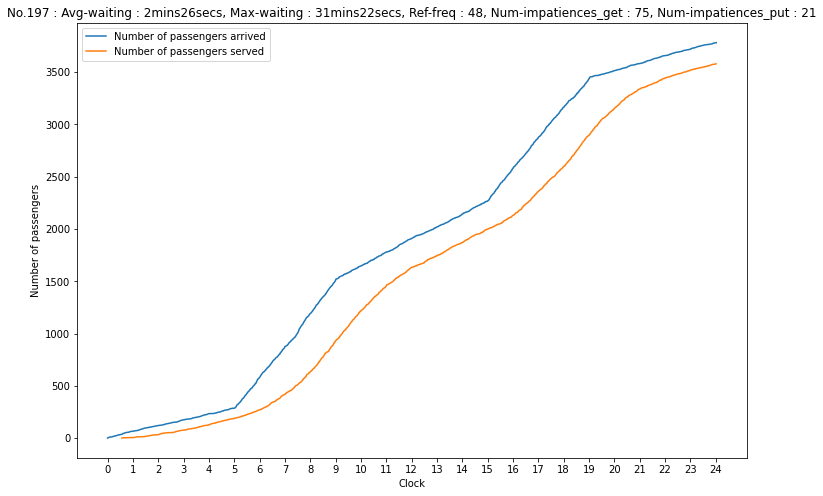

In [44]:
for id in [0]:
  x, y = (list(zip(*logs_num_passengers[res[id][0]])))
  plt.plot(x, y, label="Number of passengers arrived")
  x, y = (list(zip(*logs_num_passengers_served[res[id][0]])))
  plt.plot(x, y, label="Number of passengers served")
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.ylabel("Number of passengers")
  plt.legend(loc='best')
  plt.title(f'No.{res[id][0]} : Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.show()

## Pasenger waiting times

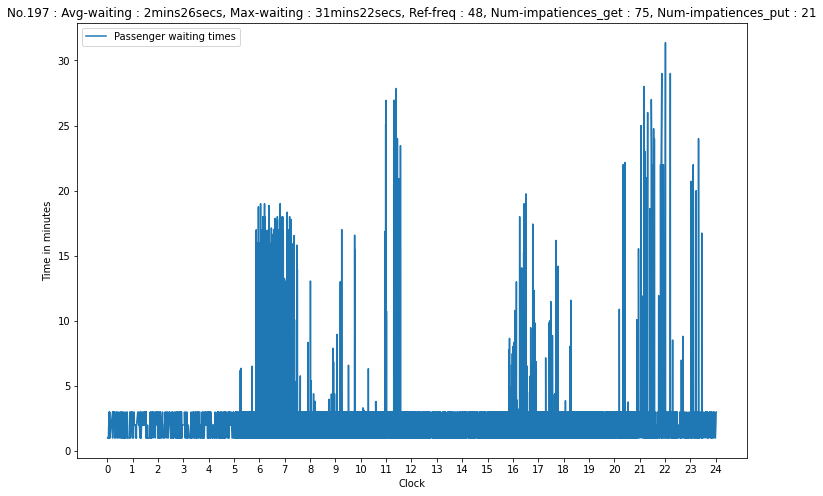

In [45]:
for id in [0]:
  x1, y1 = list(zip(*logs_wait_times[res[id][0]]))
  plt.plot(x1, y1, label='Passenger waiting times')
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.ylabel("Time in minutes")
  plt.title(f'No.{res[id][0]} : Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.legend(loc='best')
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


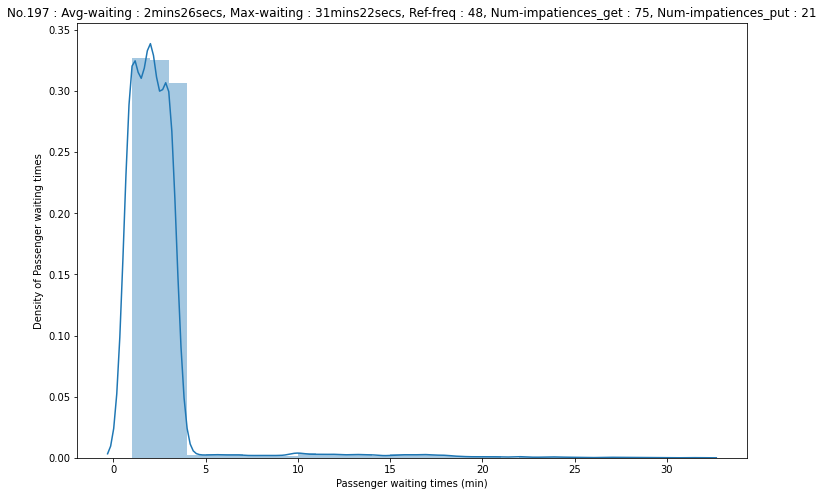

In [46]:
import seaborn as sns

for id in [0]:
  # Density Plot
  _, y = list(zip(*logs_wait_times[res[id][0]]))
  sns.distplot(y, bins=np.arange(min(y), max(y), 1), norm_hist=True)
  # plt.xticks(np.arange(min(y), max(y), 10))

  # Plot formatting
  plt.title(f'No.{res[id][0]} : Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.xlabel('Passenger waiting times (min)')
  plt.ylabel('Density of Passenger waiting times')

## N.vehicles in use

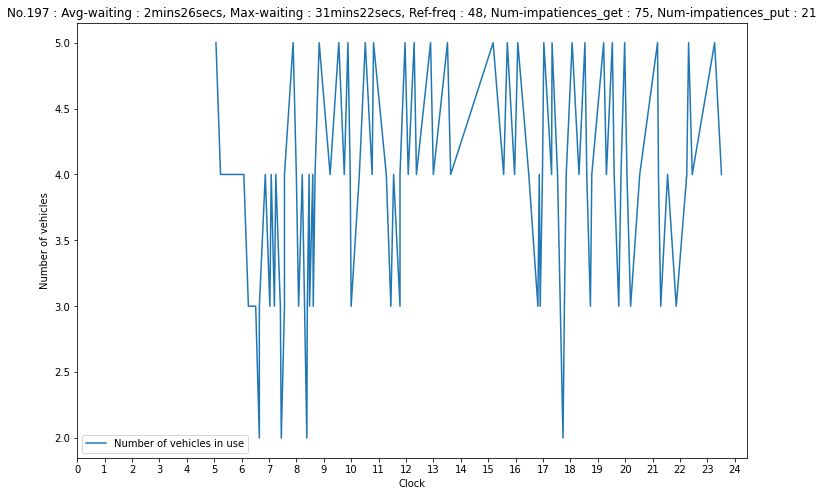

In [47]:
for id in [0]:
  x, y = (list(zip(*logs_num_vehicles_in_use[res[id][0]])))
  plt.plot(x, y, label="Number of vehicles in use")
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.ylabel("Number of vehicles")
  plt.title(f'No.{res[id][0]} : Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.legend(loc='best')
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


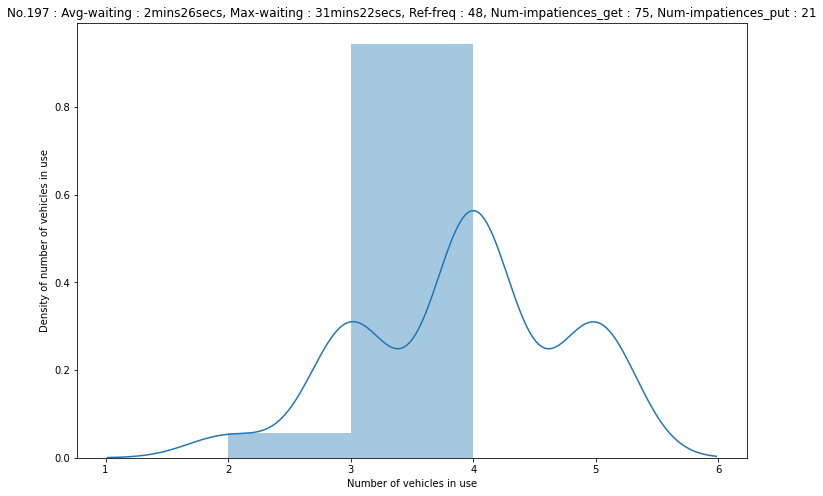

In [48]:
import seaborn as sns

for id in [0]:
  # Density Plot
  _, y = (list(zip(*logs_num_vehicles_in_use[res[id][0]])))
  sns.distplot(y, bins=np.arange(min(y), max(y), 1), norm_hist=True)

  # Plot formatting
  plt.title(f'No.{res[id][0]} : Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.xlabel('Number of vehicles in use')
  plt.ylabel('Density of number of vehicles in use')

## N.impatiences_get, N.impatiences_put

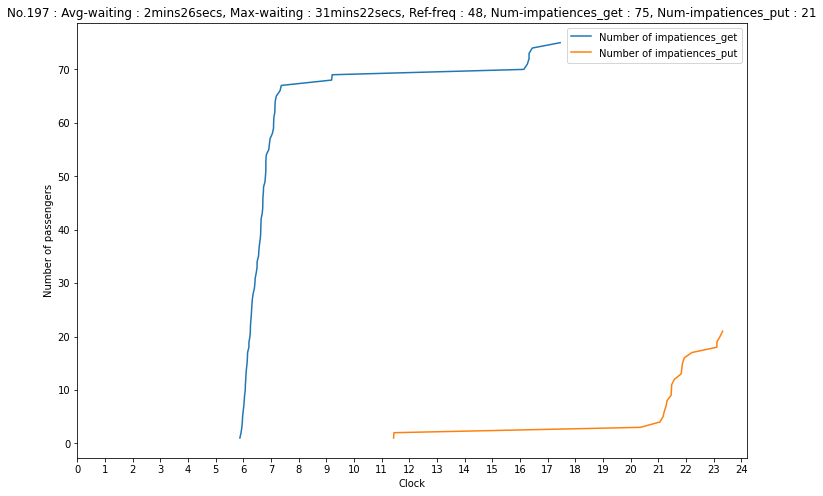

In [49]:
for id in [0]:
  if logs_num_impatiences_get[res[id][0]]:
    x1, y1 = list(zip(*logs_num_impatiences_get[res[id][0]]))
    plt.plot(x1, y1, label='Number of impatiences_get')
  if logs_num_impatiences_put[res[id][0]]:
    x2, y2 = list(zip(*logs_num_impatiences_put[res[id][0]]))
    plt.plot(x2, y2, label='Number of impatiences_put')
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.ylabel("Number of passengers")
  plt.title(f'No.{res[id][0]} : Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.legend(loc='best')
  plt.show()

## Refilling frequency

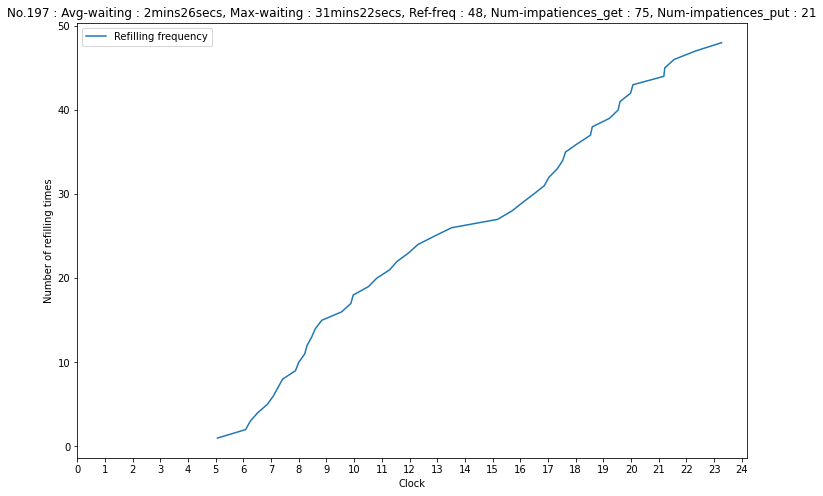

In [50]:
for id in [0]:
  x, y = (list(zip(*logs_repo_frequency[res[id][0]])))
  plt.plot(x, y, label='Refilling frequency')
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.ylabel("Number of refilling times")
  plt.title(f'No.{res[id][0]} : Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.legend(loc='best')
  plt.show()

# Case study :

## 1. Base case (no **Patience strategy**, no Refilling strategy **Refilling strategy**).

In [51]:
REFILL_FLAG = False
SHOW_RESULT_FLAG = True

# Logs
log_wait_times = []
log_repo_frequency = []
log_num_passengers = []
log_num_passengers_waiting = []
log_num_passengers_served = []
log_num_bikes_in_use = []
log_num_vehicles_in_use = []
log_num_impatiences_get = []
log_num_impatiences_put = []

# Marco variables
id = 0
repo_frequency = 0
num_impatiences_get = 0
num_impatiences_put = 0
num_passengers = 0
num_passengers_waiting = 0
num_passengers_served = 0
num_bike_in_use = 0
num_vehicles_in_use = 0
""" num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """
main(id, 5, 20, 25, 0.7, 0.1, 6, 30)

-------------------------------------------------------------------
Running simulation 0 times ... 
Num_vehicles: 5, Num_stations : 20, Capacity : 25, Init_ratio : 0.7, Reset_ratio : 0.1, Reset_threshold : 6, Reset_delay : 30
Finished at time :1442.4787275277833 
The average wait time is 4 minutes and 24 seconds. 
The max wait time is 29 minutes and 0 seconds. 
Refilling frequency : 0. 
Num_impatiences_get : 705. 
Num_impatiences_put : 9. 
Num_passengers arrived: 3713.
Num_passengers served: 2904.


(4, 24, 29, 0, 0, 705, 9)

## 2. Base case + **Patience strategy**.

In [52]:
REFILL_FLAG = False
PATIENCE_FLAG = False
SHOW_RESULT_FLAG = True

# Logs
log_wait_times = []
log_repo_frequency = []
log_num_passengers = []
log_num_passengers_waiting = []
log_num_passengers_served = []
log_num_bikes_in_use = []
log_num_vehicles_in_use = []
log_num_impatiences_get = []
log_num_impatiences_put = []

# Marco variables
id = 0
repo_frequency = 0
num_impatiences_get = 0
num_impatiences_put = 0
num_passengers = 0
num_passengers_waiting = 0
num_passengers_served = 0
num_bike_in_use = 0
num_vehicles_in_use = 0
""" num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """
main(id, 5, 20, 25, 0.7, 0.1, 6, 30)

-------------------------------------------------------------------
Running simulation 0 times ... 
Num_vehicles: 5, Num_stations : 20, Capacity : 25, Init_ratio : 0.7, Reset_ratio : 0.1, Reset_threshold : 6, Reset_delay : 30
Finished at time :1442.327486279008 
The average wait time is 33 minutes and 19 seconds. 
The max wait time is 374 minutes and 56 seconds. 
Refilling frequency : 0. 
Num_impatiences_get : 0. 
Num_impatiences_put : 0. 
Num_passengers arrived: 3743.
Num_passengers served: 3428.


(33, 19, 374, 56, 0, 0, 0)

## 3. More fine-grained search for **Num_vehieles** and results demonstration.

In [53]:
REFILL_FLAG = True
PATIENCE_FLAG = True
SHOW_RESULT_FLAG = False

res1 = []
logs1_wait_times = []
logs1_repo_frequency = []
logs1_num_passengers = []
logs1_num_passengers_waiting = []
logs1_num_passengers_served = []
logs1_num_bikes_in_use = []
logs1_num_vehicles_in_use = []
logs1_num_impatiences_get = []
logs1_num_impatiences_put = []

num_stations=20
capacity=25
init_ratio=0.7
reset_ratio=0.1
reset_threshold=6
reset_delay=30

for id, num_vehicles in enumerate([1,2,5,10,15,20]):
  # Logs
  log_wait_times = []
  log_repo_frequency = []
  log_num_passengers = []
  log_num_passengers_waiting = []
  log_num_passengers_served = []
  log_num_bikes_in_use = []
  log_num_vehicles_in_use = []
  log_num_impatiences_get = []
  log_num_impatiences_put = []

  # Marco variables
  repo_frequency = 0
  num_impatiences_get = 0
  num_impatiences_put = 0
  num_passengers = 0
  num_passengers_waiting = 0
  num_passengers_served = 0
  num_bike_in_use = 0
  num_vehicles_in_use = 0
  peak_rate = 5 # morning lambda / evening lambda
  morning_duration = 60*4 # morning peak time duration in minutes
  noon_rate = 2 # noon lambda
  noon_duration = 60*6  # noon time duration in minutes
  evening_duration = 60*4  # evening peak time duration in minutes
  night_rate = 1 # evening lambda
  night_duration = 60*10  # evening peak time duration in minutes
  """ num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """                  
  avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put = main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)
  res1.append([id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put])
  logs1_wait_times.append(log_wait_times)
  logs1_repo_frequency.append(log_repo_frequency)
  logs1_num_passengers.append(log_num_passengers)
  logs1_num_passengers_waiting.append(log_num_passengers_waiting)
  logs1_num_passengers_served.append(log_num_passengers_served)
  logs1_num_bikes_in_use.append(log_num_bikes_in_use)
  logs1_num_vehicles_in_use.append(log_num_vehicles_in_use)
  logs1_num_impatiences_get.append(log_num_impatiences_get)
  logs1_num_impatiences_put.append(log_num_impatiences_put)

In [54]:
show_table(res1)

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
0,1,25,0.7,0.1,6,30,3 mins 38 secs,30 mins 37 secs,17,409,27
1,2,25,0.7,0.1,6,30,2 mins 51 secs,29 mins 60 secs,29,111,79
2,5,25,0.7,0.1,6,30,2 mins 20 secs,28 mins 0 secs,51,50,9
3,10,25,0.7,0.1,6,30,2 mins 20 secs,28 mins 0 secs,51,50,9
4,15,25,0.7,0.1,6,30,2 mins 20 secs,28 mins 0 secs,51,50,9
5,20,25,0.7,0.1,6,30,2 mins 20 secs,28 mins 0 secs,51,50,9


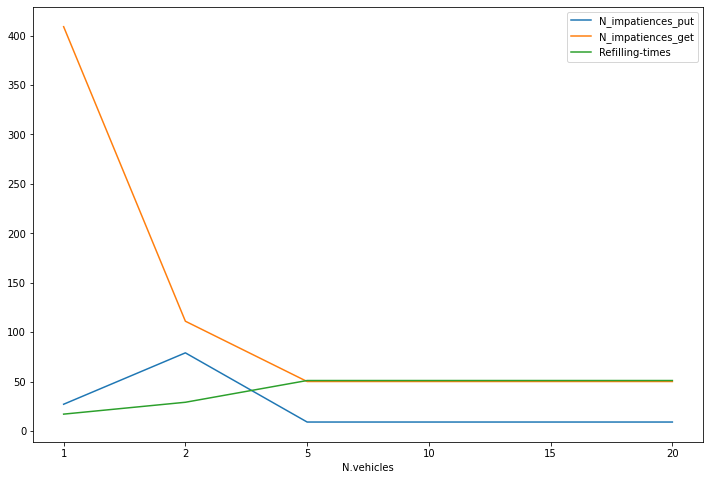

In [55]:
plt.plot(range(0,len(res1)), [row[-1] for row in res1], label='N_impatiences_put')
plt.plot(range(0,len(res1)), [row[-2] for row in res1], label='N_impatiences_get')
plt.plot(range(0,len(res1)), [row[-3] for row in res1], label='Refilling-times')
plt.xticks(range(0,len(res1)), [1,2,5,10,15,20])
plt.xlabel("N.vehicles")
plt.legend(loc='best')
plt.show()

## 4. More fine-grained search for **capacity** and results demonstration.

In [56]:
REFILL_FLAG = True
PATIENCE_FLAG = True
SHOW_RESULT_FLAG = False

res2 = []
logs2_wait_times = []
logs2_repo_frequency = []
logs2_num_passengers = []
logs2_num_passengers_waiting = []
logs2_num_passengers_served = []
logs2_num_bikes_in_use = []
logs2_num_vehicles_in_use = []
logs2_num_impatiences_get = []
logs2_num_impatiences_put = []

num_vehicles=5
num_stations=20
init_ratio=0.7
reset_ratio=0.1
reset_threshold=6
reset_delay=30

for id, capacity in enumerate([5,10,15,20,25,30,35,40,45,50]):
  # Logs
  log_wait_times = []
  log_repo_frequency = []
  log_num_passengers = []
  log_num_passengers_waiting = []
  log_num_passengers_served = []
  log_num_bikes_in_use = []
  log_num_vehicles_in_use = []
  log_num_impatiences_get = []
  log_num_impatiences_put = []

  # Marco variables
  repo_frequency = 0
  num_impatiences_get = 0
  num_impatiences_put = 0
  num_passengers = 0
  num_passengers_waiting = 0
  num_passengers_served = 0
  num_bike_in_use = 0
  num_vehicles_in_use = 0
  peak_rate = 5 # morning lambda / evening lambda
  morning_duration = 60*4 # morning peak time duration in minutes
  noon_rate = 2 # noon lambda
  noon_duration = 60*6  # noon time duration in minutes
  evening_duration = 60*4  # evening peak time duration in minutes
  night_rate = 1 # evening lambda
  night_duration = 60*10  # evening peak time duration in minutes
  """ num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """ 
  avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put = main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)
  res2.append([id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put])
  logs2_wait_times.append(log_wait_times)
  logs2_repo_frequency.append(log_repo_frequency)
  logs2_num_passengers.append(log_num_passengers)
  logs2_num_passengers_waiting.append(log_num_passengers_waiting)
  logs2_num_passengers_served.append(log_num_passengers_served)
  logs2_num_bikes_in_use.append(log_num_bikes_in_use)
  logs2_num_vehicles_in_use.append(log_num_vehicles_in_use)
  logs2_num_impatiences_get.append(log_num_impatiences_get)
  logs2_num_impatiences_put.append(log_num_impatiences_put)

In [57]:
show_table(res2)

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
0,5,5,0.7,0.1,6,30,6 mins 41 secs,30 mins 38 secs,86,1032,142
1,5,10,0.7,0.1,6,30,4 mins 25 secs,29 mins 19 secs,79,320,152
2,5,15,0.7,0.1,6,30,3 mins 25 secs,30 mins 18 secs,63,222,85
3,5,20,0.7,0.1,6,30,2 mins 29 secs,29 mins 0 secs,67,35,28
4,5,25,0.7,0.1,6,30,2 mins 20 secs,28 mins 0 secs,51,50,9
5,5,30,0.7,0.1,6,30,2 mins 10 secs,25 mins 0 secs,52,26,2
6,5,35,0.7,0.1,6,30,2 mins 4 secs,27 mins 0 secs,38,0,9
7,5,40,0.7,0.1,6,30,2 mins 2 secs,29 mins 0 secs,40,3,7
8,5,45,0.7,0.1,6,30,2 mins 1 secs,25 mins 0 secs,28,0,5
9,5,50,0.7,0.1,6,30,1 mins 58 secs,3 mins 32 secs,29,0,0


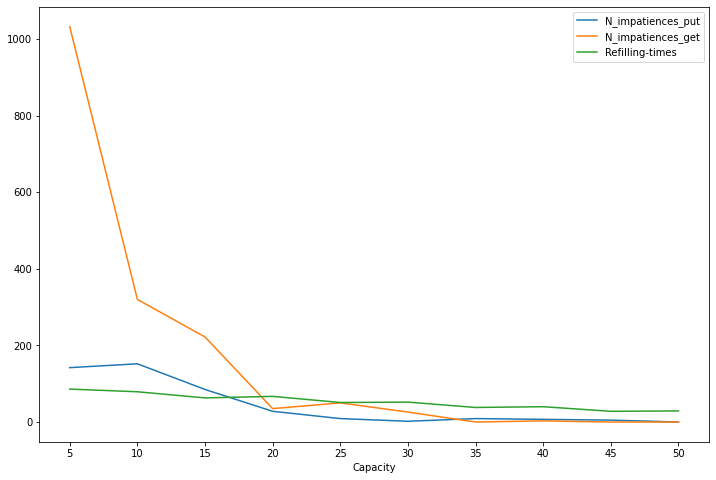

In [58]:
plt.plot(range(0,len(res2)), [row[-1] for row in res2], label='N_impatiences_put')
plt.plot(range(0,len(res2)), [row[-2] for row in res2], label='N_impatiences_get')
plt.plot(range(0,len(res2)), [row[-3] for row in res2], label='Refilling-times')
plt.xticks(range(0,len(res2)), [5,10,15,20,25,30,35,40,45,50])
plt.xlabel("Capacity")
plt.legend(loc='best')
plt.show()

## 5. More fine-grained search for **init_ratio** and results demonstration.

In [59]:
REFILL_FLAG = True
PATIENCE_FLAG = True
SHOW_RESULT_FLAG = False

res3 = []
logs3_wait_times = []
logs3_repo_frequency = []
logs3_num_passengers = []
logs3_num_passengers_waiting = []
logs3_num_passengers_served = []
logs3_num_bikes_in_use = []
logs3_num_vehicles_in_use = []
logs3_num_impatiences_get = []
logs3_num_impatiences_put = []

num_vehicles=5
num_stations=20
capacity=25
reset_ratio=0.1
reset_threshold=6
reset_delay=30

for id, init_ratio in enumerate([0.5,0.6,0.7,0.8,0.9]):
  # Logs
  log_wait_times = []
  log_repo_frequency = []
  log_num_passengers = []
  log_num_passengers_waiting = []
  log_num_passengers_served = []
  log_num_bikes_in_use = []
  log_num_vehicles_in_use = []
  log_num_impatiences_get = []
  log_num_impatiences_put = []

  # Marco variables
  repo_frequency = 0
  num_impatiences_get = 0
  num_impatiences_put = 0
  num_passengers = 0
  num_passengers_waiting = 0
  num_passengers_served = 0
  num_bike_in_use = 0
  num_vehicles_in_use = 0
  peak_rate = 5 # morning lambda / evening lambda
  morning_duration = 60*4 # morning peak time duration in minutes
  noon_rate = 2 # noon lambda
  noon_duration = 60*6  # noon time duration in minutes
  evening_duration = 60*4  # evening peak time duration in minutes
  night_rate = 1 # evening lambda
  night_duration = 60*10  # evening peak time duration in minutes
  """ num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """
  avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put = main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)
  res3.append([id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put])
  logs3_wait_times.append(log_wait_times)
  logs3_repo_frequency.append(log_repo_frequency)
  logs3_num_passengers.append(log_num_passengers)
  logs3_num_passengers_waiting.append(log_num_passengers_waiting)
  logs3_num_passengers_served.append(log_num_passengers_served)
  logs3_num_bikes_in_use.append(log_num_bikes_in_use)
  logs3_num_vehicles_in_use.append(log_num_vehicles_in_use)
  logs3_num_impatiences_get.append(log_num_impatiences_get)
  logs3_num_impatiences_put.append(log_num_impatiences_put)

In [60]:
show_table(res3)

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
0,5,25,0.5,0.1,6,30,2 mins 23 secs,29 mins 0 secs,59,31,28
1,5,25,0.6,0.1,6,30,2 mins 26 secs,31 mins 12 secs,52,85,15
2,5,25,0.7,0.1,6,30,2 mins 20 secs,28 mins 0 secs,51,50,9
3,5,25,0.8,0.1,6,30,2 mins 21 secs,29 mins 0 secs,59,53,17
4,5,25,0.9,0.1,6,30,2 mins 35 secs,29 mins 0 secs,60,107,19


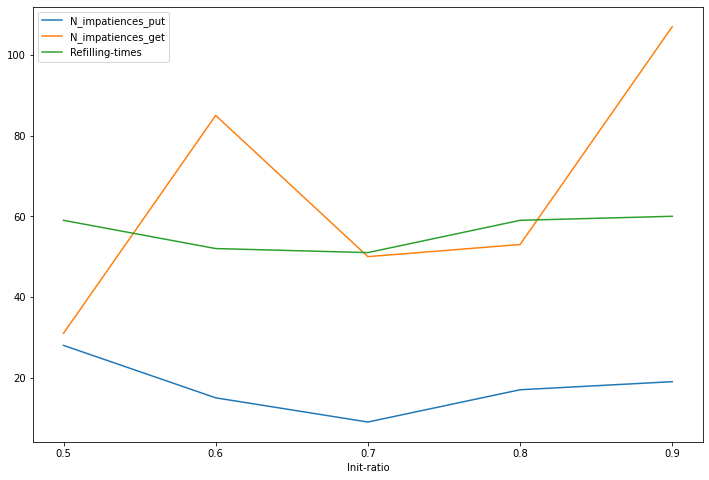

In [61]:
plt.plot(range(0,len(res3)), [row[-1] for row in res3], label='N_impatiences_put')
plt.plot(range(0,len(res3)), [row[-2] for row in res3], label='N_impatiences_get')
plt.plot(range(0,len(res3)), [row[-3] for row in res3], label='Refilling-times')
plt.xticks(range(0,len(res3)), [0.5,0.6,0.7,0.8,0.9])
plt.xlabel("Init-ratio")
plt.legend(loc='best')
plt.show()

## 6. More fine-grained search for **reset_ratio** and results demonstration.

In [62]:
REFILL_FLAG = True
PATIENCE_FLAG = True
SHOW_RESULT_FLAG = False

res4 = []
logs4_wait_times = []
logs4_repo_frequency = []
logs4_num_passengers = []
logs4_num_passengers_waiting = []
logs4_num_passengers_served = []
logs4_num_bikes_in_use = []
logs4_num_vehicles_in_use = []
logs4_num_impatiences_get = []
logs4_num_impatiences_put = []

num_vehicles=5
num_stations=20
capacity=25
init_ratio=0.7
reset_threshold=6
reset_delay=30

for id, reset_ratio in enumerate([0.1,0.2,0.3,0.4,0.5]):
  # Logs
  log_wait_times = []
  log_repo_frequency = []
  log_num_passengers = []
  log_num_passengers_waiting = []
  log_num_passengers_served = []
  log_num_bikes_in_use = []
  log_num_vehicles_in_use = []
  log_num_impatiences_get = []
  log_num_impatiences_put = []

  # Marco variables
  repo_frequency = 0
  num_impatiences_get = 0
  num_impatiences_put = 0
  num_passengers = 0
  num_passengers_waiting = 0
  num_passengers_served = 0
  num_bike_in_use = 0
  num_vehicles_in_use = 0
  peak_rate = 5 # morning lambda / evening lambda
  morning_duration = 60*4 # morning peak time duration in minutes
  noon_rate = 2 # noon lambda
  noon_duration = 60*6  # noon time duration in minutes
  evening_duration = 60*4  # evening peak time duration in minutes
  night_rate = 1 # evening lambda
  night_duration = 60*10  # evening peak time duration in minutes
  """ num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """
  avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put = main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)
  res4.append([id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put])
  logs4_wait_times.append(log_wait_times)
  logs4_repo_frequency.append(log_repo_frequency)
  logs4_num_passengers.append(log_num_passengers)
  logs4_num_passengers_waiting.append(log_num_passengers_waiting)
  logs4_num_passengers_served.append(log_num_passengers_served)
  logs4_num_bikes_in_use.append(log_num_bikes_in_use)
  logs4_num_vehicles_in_use.append(log_num_vehicles_in_use)
  logs4_num_impatiences_get.append(log_num_impatiences_get)
  logs4_num_impatiences_put.append(log_num_impatiences_put)

In [63]:
show_table(res4)

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
0,5,25,0.7,0.1,6,30,2 mins 20 secs,28 mins 0 secs,51,50,9
1,5,25,0.7,0.2,6,30,2 mins 13 secs,29 mins 0 secs,67,27,17
2,5,25,0.7,0.3,6,30,2 mins 9 secs,29 mins 0 secs,75,25,6
3,5,25,0.7,0.4,6,30,2 mins 21 secs,30 mins 46 secs,89,54,36
4,5,25,0.7,0.5,6,30,2 mins 54 secs,29 mins 60 secs,89,93,112


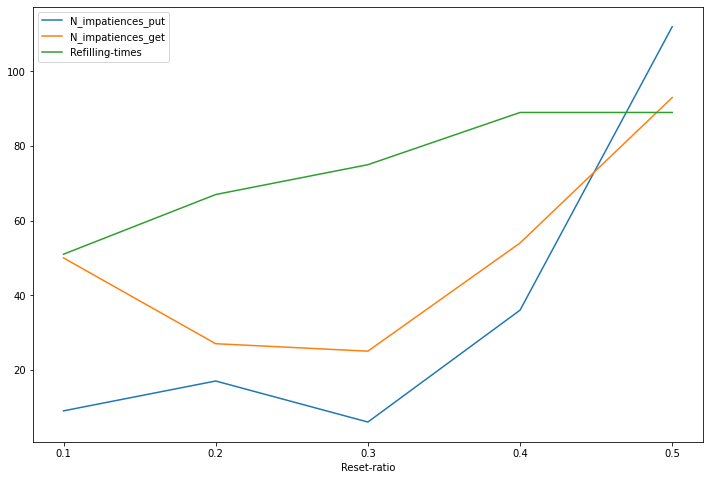

In [64]:
plt.plot(range(0,len(res4)), [row[-1] for row in res4], label='N_impatiences_put')
plt.plot(range(0,len(res4)), [row[-2] for row in res4], label='N_impatiences_get')
plt.plot(range(0,len(res4)), [row[-3] for row in res4], label='Refilling-times')
plt.xticks(range(0,len(res4)), [0.1,0.2,0.3,0.4,0.5])
plt.xlabel("Reset-ratio")
plt.legend(loc='best')
plt.show()

## 7. More fine-grained search for **reset_threshold** and results demonstration.

In [65]:
REFILL_FLAG = True
PATIENCE_FLAG = True
SHOW_RESULT_FLAG = False

res5 = []
logs5_wait_times = []
logs5_repo_frequency = []
logs5_num_passengers = []
logs5_num_passengers_waiting = []
logs5_num_passengers_served = []
logs5_num_bikes_in_use = []
logs5_num_vehicles_in_use = []
logs5_num_impatiences_get = []
logs5_num_impatiences_put = []

num_vehicles=5
num_stations=20
capacity=25
init_ratio=0.7
reset_ratio=0.1
reset_delay=30

for id, reset_threshold in enumerate([4,5,6,7,8,9]):
  # Logs
  log_wait_times = []
  log_repo_frequency = []
  log_num_passengers = []
  log_num_passengers_waiting = []
  log_num_passengers_served = []
  log_num_bikes_in_use = []
  log_num_vehicles_in_use = []
  log_num_impatiences_get = []
  log_num_impatiences_put = []

  # Marco variables
  repo_frequency = 0
  num_impatiences_get = 0
  num_impatiences_put = 0
  num_passengers = 0
  num_passengers_waiting = 0
  num_passengers_served = 0
  num_bike_in_use = 0
  num_vehicles_in_use = 0
  peak_rate = 5 # morning lambda / evening lambda
  morning_duration = 60*4 # morning peak time duration in minutes
  noon_rate = 2 # noon lambda
  noon_duration = 60*6  # noon time duration in minutes
  evening_duration = 60*4  # evening peak time duration in minutes
  night_rate = 1 # evening lambda
  night_duration = 60*10  # evening peak time duration in minutes
  """ num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """
  avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put = main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)
  res5.append([id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put])
  logs5_wait_times.append(log_wait_times)
  logs5_repo_frequency.append(log_repo_frequency)
  logs5_num_passengers.append(log_num_passengers)
  logs5_num_passengers_waiting.append(log_num_passengers_waiting)
  logs5_num_passengers_served.append(log_num_passengers_served)
  logs5_num_bikes_in_use.append(log_num_bikes_in_use)
  logs5_num_vehicles_in_use.append(log_num_vehicles_in_use)
  logs5_num_impatiences_get.append(log_num_impatiences_get)
  logs5_num_impatiences_put.append(log_num_impatiences_put)

In [66]:
show_table(res5)

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
0,5,25,0.7,0.1,4,30,2 mins 21 secs,28 mins 10 secs,60,46,12
1,5,25,0.7,0.1,5,30,2 mins 29 secs,30 mins 24 secs,53,65,26
2,5,25,0.7,0.1,6,30,2 mins 20 secs,28 mins 0 secs,51,50,9
3,5,25,0.7,0.1,7,30,2 mins 26 secs,30 mins 22 secs,51,51,16
4,5,25,0.7,0.1,8,30,2 mins 26 secs,31 mins 22 secs,48,75,21
5,5,25,0.7,0.1,9,30,2 mins 25 secs,29 mins 5 secs,53,68,10


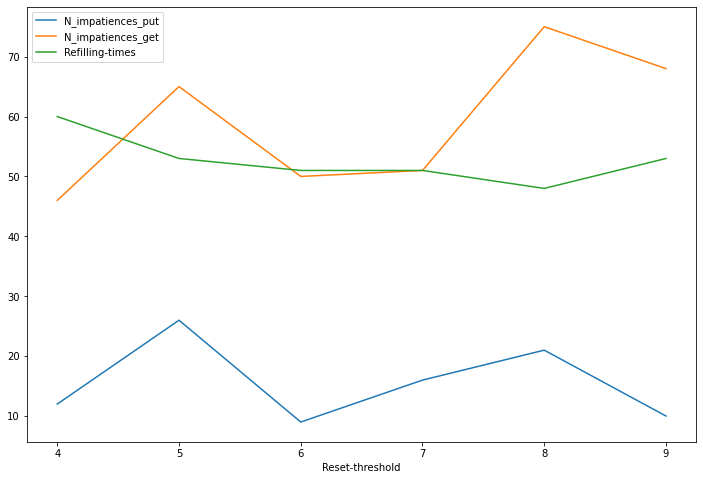

In [67]:
plt.plot(range(0,len(res5)), [row[-1] for row in res5], label='N_impatiences_put')
plt.plot(range(0,len(res5)), [row[-2] for row in res5], label='N_impatiences_get')
plt.plot(range(0,len(res5)), [row[-3] for row in res5], label='Refilling-times')
plt.xticks(range(0,len(res5)), [4,5,6,7,8,9])
plt.xlabel("Reset-threshold")
plt.legend(loc='best')
plt.show()

## 8. More fine-grained search for **reset_delay** and results demonstration.

In [68]:
REFILL_FLAG = True
PATIENCE_FLAG = True
SHOW_RESULT_FLAG = False

res6 = []
logs6_wait_times = []
logs6_repo_frequency = []
logs6_num_passengers = []
logs6_num_passengers_waiting = []
logs6_num_passengers_served = []
logs6_num_bikes_in_use = []
logs6_num_vehicles_in_use = []
logs6_num_impatiences_get = []
logs6_num_impatiences_put = []

num_vehicles=5
num_stations=20
capacity=25
init_ratio=0.7
reset_ratio=0.1
reset_threshold=6

for id, reset_delay in enumerate([1,2,5,10,20,30,40,50,60]):
  # Logs
  log_wait_times = []
  log_repo_frequency = []
  log_num_passengers = []
  log_num_passengers_waiting = []
  log_num_passengers_served = []
  log_num_bikes_in_use = []
  log_num_vehicles_in_use = []
  log_num_impatiences_get = []
  log_num_impatiences_put = []

  # Marco variables
  repo_frequency = 0
  num_impatiences_get = 0
  num_impatiences_put = 0
  num_passengers = 0
  num_passengers_waiting = 0
  num_passengers_served = 0
  num_bike_in_use = 0
  num_vehicles_in_use = 0
  peak_rate = 5 # morning lambda / evening lambda
  morning_duration = 60*4 # morning peak time duration in minutes
  noon_rate = 2 # noon lambda
  noon_duration = 60*6  # noon time duration in minutes
  evening_duration = 60*4  # evening peak time duration in minutes
  night_rate = 1 # evening lambda
  night_duration = 60*10  # evening peak time duration in minutes
  """ num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """
  avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put = main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)
  res6.append([id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put])
  logs6_wait_times.append(log_wait_times)
  logs6_repo_frequency.append(log_repo_frequency)
  logs6_num_passengers.append(log_num_passengers)
  logs6_num_passengers_waiting.append(log_num_passengers_waiting)
  logs6_num_passengers_served.append(log_num_passengers_served)
  logs6_num_bikes_in_use.append(log_num_bikes_in_use)
  logs6_num_vehicles_in_use.append(log_num_vehicles_in_use)
  logs6_num_impatiences_get.append(log_num_impatiences_get)
  logs6_num_impatiences_put.append(log_num_impatiences_put)

In [69]:
show_table(res6)

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waiting-time,Max-waiting-time,Refilling-times,N_impatiences_get,N_impatiences_put
0,5,25,0.7,0.1,6,1,2 mins 1 secs,9 mins 49 secs,121,0,0
1,5,25,0.7,0.1,6,2,2 mins 1 secs,11 mins 19 secs,111,0,0
2,5,25,0.7,0.1,6,5,2 mins 1 secs,16 mins 9 secs,86,0,0
3,5,25,0.7,0.1,6,10,2 mins 8 secs,19 mins 33 secs,69,24,0
4,5,25,0.7,0.1,6,20,2 mins 16 secs,28 mins 0 secs,62,28,7
5,5,25,0.7,0.1,6,30,2 mins 20 secs,28 mins 0 secs,51,50,9
6,5,25,0.7,0.1,6,40,2 mins 40 secs,29 mins 58 secs,41,135,25
7,5,25,0.7,0.1,6,50,2 mins 36 secs,30 mins 37 secs,35,113,23
8,5,25,0.7,0.1,6,60,2 mins 38 secs,30 mins 27 secs,36,73,56


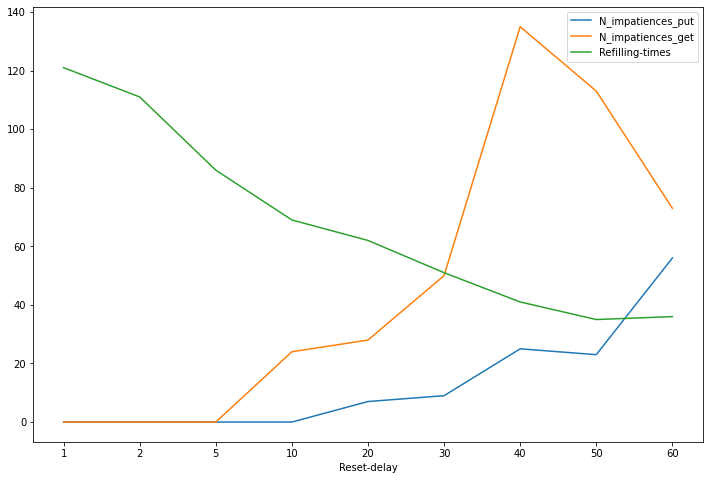

In [70]:
plt.plot(range(0,len(res6)), [row[-1] for row in res6], label='N_impatiences_put')
plt.plot(range(0,len(res6)), [row[-2] for row in res6], label='N_impatiences_get')
plt.plot(range(0,len(res6)), [row[-3] for row in res6], label='Refilling-times')
plt.xticks(range(0,len(res6)), [1,2,5,10,20,30,40,50,60])
plt.xlabel("Reset-delay")
plt.legend(loc='best')
plt.show()